In [1]:
import os
import sys
dirof = os.path.dirname
sys.path.append('/home/longshen/work/AccGen/AccGen')
import torch

In [2]:
# Prepare tokenizer
from transformers import PreTrainedTokenizerFast
tokenizer_path = 'LongshenOu/phrase-vae-tokenizer'
tok = PreTrainedTokenizerFast.from_pretrained(tokenizer_path)

/home/longshen/programs/miniconda3/envs/accgen/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Prepare data
data_fp = '/data1/longshen/Datasets/Piano/POP909/latents/pop909_piano_track_bars.pt'
data = torch.load(data_fp)
print(data.shape)

torch.Size([75703, 4, 512])


In [5]:
# PCA to 2D
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
data_np = data.cpu().numpy()
data_np = data_np.reshape(data_np.shape[0], -1)
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data_np)
print(data_2d.shape)

(75703, 2)


In [6]:
# Print statistics
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(pca.explained_variance_ratio_))
print("Total explained variance:", np.sum(pca.explained_variance_ratio_))


Explained variance ratio: [0.02022687 0.01685148]
Cumulative explained variance: [0.02022687 0.03707835]
Total explained variance: 0.03707835


(75703, 2)
Explained variance ratio: [0.02022703 0.01685507]
Cumulative explained variance ratio: [0.02022703 0.0370821 ]


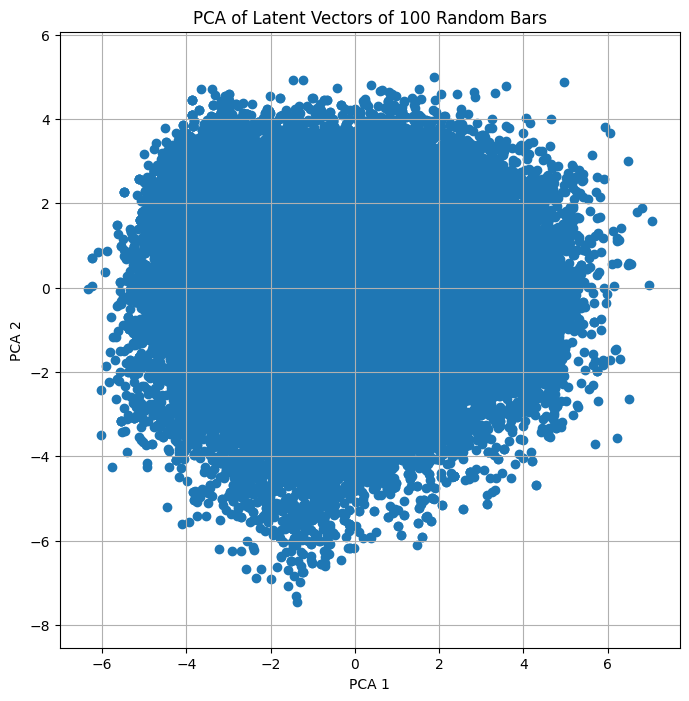

In [7]:
# PCA to 2D
from sklearn.decomposition import PCA
import numpy as np
latents_array = data.cpu().numpy()  # (100, 16, 128)
latents_array_2d = latents_array.reshape(latents_array.shape[0], -1)  # (100, 2048)
pca = PCA(n_components=2)
latents_pca = pca.fit_transform(latents_array_2d)  # (100, 2)
print(latents_pca.shape)
print('Explained variance ratio:', pca.explained_variance_ratio_)
print('Cumulative explained variance ratio:', np.cumsum(pca.explained_variance_ratio_))
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.scatter(latents_pca[:, 0], latents_pca[:, 1])
# for i, idx in enumerate(bar_indices):
#     plt.annotate(str(idx), (latents_pca[i, 0], latents_pca[i, 1]))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of Latent Vectors of 100 Random Bars')
plt.grid()
plt.axis('equal')
plt.show()

(75703, 3)
Explained variance ratio: [0.02022701 0.01685525 0.01465858]
Cumulative explained variance ratio: [0.02022701 0.03708226 0.05174084]


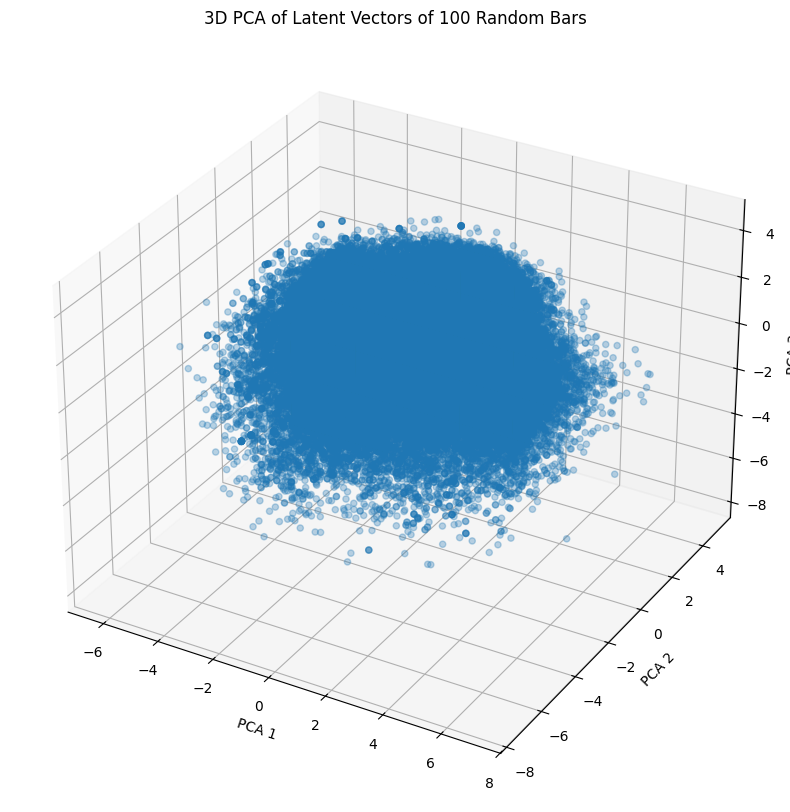

In [8]:
# 3D PCA
from mpl_toolkits.mplot3d import Axes3D
pca_3d = PCA(n_components=3)
latents_pca_3d = pca_3d.fit_transform(latents_array_2d)  # (100, 3)
print(latents_pca_3d.shape)
print('Explained variance ratio:', pca_3d.explained_variance_ratio_)
print('Cumulative explained variance ratio:', np.cumsum(pca_3d.explained_variance_ratio_))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(latents_pca_3d[:, 0], latents_pca_3d[:, 1], latents_pca_3d[:, 2], alpha=0.3)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('3D PCA of Latent Vectors of 100 Random Bars')
plt.show()

In [26]:
import plotly.graph_objects as go
import numpy as np
from sklearn.decomposition import PCA

# 示例：latents_array 是 shape=(N, D) 的 numpy 数组
# bar_indices 是对应的编号 list 或 array，长度为 N

# 降维
pca = PCA(n_components=3)
latents_array_2d = latents_array.reshape(latents_array.shape[0], -1)  # (100, 2048)
latents_pca_3d = pca.fit_transform(latents_array_2d)

# 创建 plotly figure
fig = go.Figure(data=[go.Scatter3d(
    x=latents_pca_3d[:, 0],
    y=latents_pca_3d[:, 1],
    z=latents_pca_3d[:, 2],
    mode='markers+text',
    marker=dict(
        size=3,
        color=np.arange(len(latents_pca_3d)),  # 可换成别的类别标签
        colorscale='Viridis',
        opacity=0.7
    ),
    text=[str(i) if i % 500 == 0 else '' for i in bar_indices],  # 稀疏标注
    textposition='top center'
)])

# 设置图形参数
fig.update_layout(
    title='Interactive 3D PCA of Bar Latents',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3',
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    height=800
)

# 显示
fig.write_html("bar_latents_pca.html")

In [35]:
import numpy as np
from sklearn.cluster import KMeans
import plotly.express as px

# 假设这些都已经准备好了
# latents_pca_3d: (N, 3)
# bar_indices: 长度 N 的列表（可以是 sample id 或者 bar index）

# 聚类
kmeans = KMeans(n_clusters=10, random_state=42).fit(latents_pca_3d)
labels = kmeans.labels_

# 构建 text 注释：每 500 个加一次
text_labels = []
for i, idx in enumerate(bar_indices):
    if i % 500 == 0:
        text_labels.append(str(idx))
    else:
        text_labels.append("")  # 空就不会显示

# 构建 hover 信息
hover_texts = [f"Index: {idx}<br>Cluster: {label}" for idx, label in zip(bar_indices, labels)]

# 创建 Plotly 3D 图
fig = px.scatter_3d(
    x=latents_pca_3d[:, 0],
    y=latents_pca_3d[:, 1],
    z=latents_pca_3d[:, 2],
    color=labels.astype(str),
    text=text_labels,         # 显示在图中的 annotation
    hover_name=hover_texts    # 鼠标悬停时显示的信息
)

# 设置文本字体和 hover 样式（可选）
fig.update_traces(textposition='top center', marker=dict(size=3))

# 保存为 HTML
fig.write_html("bar_latents_pca_clustering.html")

Then I try to see the cluster centers

In [40]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=10).fit(latents_array_2d)  # 或 latents_raw
cluster_centers = kmeans.cluster_centers_  # shape: (10, latent_dim)

In [44]:
# 假设你的 decoder 是 model.decode(latent)
from sonata_utils import jpath
save_dir = '/home/longshen/work/AccGen/AccGen/tests/clustering_centers'
cnt = 0
for center in cluster_centers:
    # reshape to (4, 512)
    latent = center.reshape(4, 512)
    latent = torch.from_numpy(latent).float()
    proll, mt = get_piano_roll_from_latents(model, tok, latent)
    save_fp = jpath(save_dir, f'cluster_center_{cnt}.mid')
    mt.to_midi(save_fp)
    cnt += 1


MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/clustering_centers/cluster_center_0.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/clustering_centers/cluster_center_1.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/clustering_centers/cluster_center_2.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/clustering_centers/cluster_center_3.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/clustering_centers/cluster_center_4.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/clustering_centers/cluster_center_5.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/clustering_centers/cluster_center_6.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/clustering_centers/cluster_center_7.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/clustering_cen